In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import configs
import os
from auxrl.Agent import Agent
from auxrl.networks.Network import Network
import yaml
from auxrl.environments.PoortTask import Env as Env 
from acme import specs

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
if os.environ['LOGNAME'] == 'chingfang':
    engram_dir = '/Volumes/aronov-locker/Ching/rl/'
else:
    engram_dir = '/mnt/smb/locker/aronov-locker/Ching/rl/'

# Data Collection Helper Functions

In [31]:
def get_responses(model, _iter, epoch):
    fname = f'{base_exp}_{model}'
    fname_nnet_dir = f'{engram_dir}nnets/{exp}/{fname}_{_iter}/'
    with open(f'{engram_dir}params/{exp}/{fname}.yaml', 'r') as f:
        parameters = yaml.safe_load(f)
    parameters['fname'] = f'{exp}/{fname}_{_iter}'
    parameters['internal_dim'] = dim
    parameters['nn_yaml'] = nn_yaml
    
    np.random.seed(_iter)
    env = Env(**parameters['dset_args'])
    np.random.seed()
    env_spec = specs.make_environment_spec(env)
    network = Network(env_spec, device=device, **parameters['network_args'])
    agent = Agent(env_spec, network, device=device, **parameters['agent_args'])
    if epoch is not None:
        try:
            agent.load_network(fname_nnet_dir, episode=epoch, encoder_only=False)
        except:
            return None, None, None, None

    vertical_response = []
    angled_response = []
    approach_response = []
    n_states = 3
    all_responses = []

    for shift in range(env.n_approach_states):
        approach_state = env.approach_states[shift]
        obs = torch.tensor(approach_state).float().unsqueeze(0).unsqueeze(0)
        agent._network.encoder(obs, save_conv_activity=True)
        conv_activity = agent._network.encoder._prev_conv_activity.numpy()
        if shift < n_states:
            approach_response.append(conv_activity)
        all_responses.append(conv_activity)

    for shift in range(env.n_grating_states):
        obs = np.roll(env.base_vertical_state, -shift)
        obs = torch.tensor(obs).float().unsqueeze(0).unsqueeze(0)
        agent._network.encoder(obs, save_conv_activity=True)
        conv_activity = agent._network.encoder._prev_conv_activity.numpy()
        if shift < n_states:
            vertical_response.append(conv_activity)
        all_responses.append(conv_activity)

    for shift in range(env.n_grating_states):
        obs = np.roll(env.base_angled_state, -shift)
        obs = torch.tensor(obs).float().unsqueeze(0).unsqueeze(0)
        agent._network.encoder(obs, save_conv_activity=True)
        conv_activity = agent._network.encoder._prev_conv_activity.numpy()
        if shift < n_states:
            angled_response.append(conv_activity)
        all_responses.append(conv_activity)

    vertical_response = np.array(vertical_response).reshape((n_states,-1))
    angled_response = np.array(angled_response).reshape((n_states,-1))
    approach_response = np.array(approach_response).reshape((n_states,-1))
    all_responses = np.array(all_responses).squeeze()
    all_responses = all_responses.reshape((all_responses.shape[0],-1))
    return vertical_response, angled_response, approach_response, all_responses

In [23]:
def add_popln_metrics(results):
    results['vert_mean'] = np.mean(results['vert'], axis=0)
    results['angle_mean'] = np.mean(results['angle'], axis=0)
    results['approach_mean'] = np.mean(results['approach'], axis=0)
#     results['popln_std'] = np.std(
#         np.vstack((results['vert'], results['angle'])), axis=0)
    results['popln_std'] = np.std(results['all'], axis=0)
    results['si'] = np.divide((
        results['vert_mean'] - results['angle_mean']),
        results['popln_std'] + 1E-10)
    results['popln_si'] = np.sqrt(np.square(results['si']).mean())

In [24]:
def get_pre_post_data(model):
    data = []
    for _iter in range(30):
        _data = {'pre': {}, 'post': {}}
        pre_v, pre_a, pre_app, pre_all = get_responses(model, _iter, pre_epoch)
        post_v, post_a, post_app, post_all = get_responses(model, _iter, post_epoch)
        if pre_v is None or post_v is None: continue
        _data['pre']['vert'] = pre_v
        _data['pre']['angle'] = pre_a
        _data['pre']['approach'] = pre_app
        _data['pre']['all'] = pre_all
        _data['post']['vert'] = post_v
        _data['post']['angle'] = post_a
        _data['post']['approach'] = post_app
        _data['post']['all'] = post_all
        add_popln_metrics(_data['pre'])
        add_popln_metrics(_data['post'])
        data.append(_data)
    return data

# Plotting Helper Functions

In [25]:
def plot_selectivity_bar_change(data, thresh=0.25):
    df = {'Condition': [], 'Selectivity': [], 'Proportion': []}
    for _data in data:
        n_neurons = _data['pre']['si'].size
        v_s = np.sum(_data['pre']['si'] > thresh)/n_neurons
        a_s = np.sum(_data['pre']['si'] < -thresh)/n_neurons
        n_s = np.sum(np.abs(_data['pre']['si']) <= thresh)/n_neurons
        df['Condition'].extend(['Pre-Learning']*3)
        df['Selectivity'].extend(['Vertical', 'Angled', 'No Preference'])
        df['Proportion'].extend([v_s, a_s, n_s])
        v_s = np.sum(_data['post']['si'] > thresh)/n_neurons
        a_s = np.sum(_data['post']['si'] < -thresh)/n_neurons
        n_s = np.sum(np.abs(_data['post']['si']) <= thresh)/n_neurons
        df['Condition'].extend(['Post-Learning']*3)
        df['Selectivity'].extend(['Vertical', 'Angled', 'No Preference'])
        df['Proportion'].extend([v_s, a_s, n_s])
    df = pd.DataFrame(df)

    fig, ax = plt.subplots(figsize=(5, 2.5))
    sns.barplot(x='Selectivity', y='Proportion', hue='Condition', data=df)
    plt.show()

In [26]:
from scipy.stats import norm

In [27]:
def plot_selectivity_distribution_change(data, step_size=0.5):
    df = {'Condition': [], 'SI': []}
    for _data in data:
        n_neurons = _data['pre']['si'].size
        df['Condition'].extend(['Pre-Learning']*n_neurons)
        df['SI'].extend(_data['pre']['si'].tolist())
        df['Condition'].extend(['Post-Learning']*n_neurons)
        df['SI'].extend(_data['post']['si'].tolist())
    df = pd.DataFrame(df)
    
    fig, ax = plt.subplots(figsize=(5, 2.5))
    pre_data = df[df['Condition']=='Pre-Learning']['SI']
    post_data = df[df['Condition']=='Post-Learning']['SI']
    plt.hist(pre_data, bins=15, density=True, alpha=0.3, color='C0')
    plt.hist(post_data, bins=15, density=True, alpha=0.3, color='C1')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 1000)
    mu, std = norm.fit(pre_data)
    p = norm.pdf(x, mu, std)
    plt.scatter(mu, norm.pdf(mu, mu, std), color='C0', alpha=0.8, s=20)
    plt.plot(x, p, 'C0', linewidth=2)
    mu, std = norm.fit(post_data)
    p = norm.pdf(x, mu, std)
    plt.scatter(mu, norm.pdf(mu, mu, std), color='C1', alpha=0.8, s=20)
    plt.plot(x, p, 'C1', linewidth=2)
    ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
    plt.show()

# Population Analysis

In [71]:
pre_epoch = 0
post_epoch = 300
dim = 32
nn_yaml = 'dm'
base_exp = 'poorttask_flipped_clipnorm.05'
exp = f'{base_exp}_{nn_yaml}_dim{dim}'

In [72]:
data = get_pre_post_data('mf0')

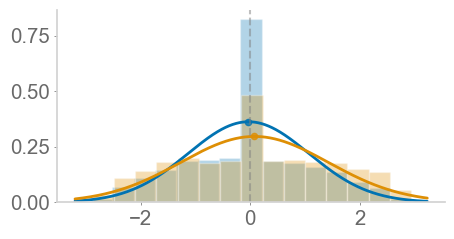

In [73]:
plot_selectivity_distribution_change(data)

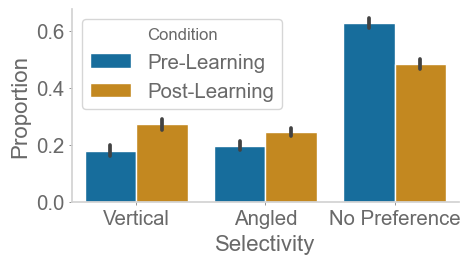

In [74]:
plot_selectivity_bar_change(data, thresh=1)

In [75]:
data = get_pre_post_data('noq_g0_-1_entro-2')

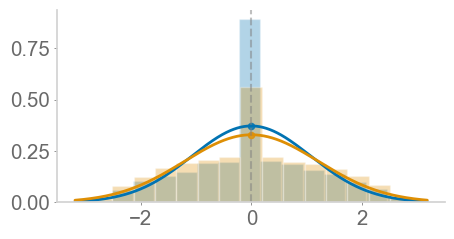

In [76]:
plot_selectivity_distribution_change(data)

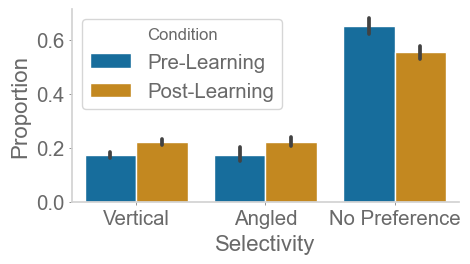

In [77]:
plot_selectivity_bar_change(data, thresh=1)

In [78]:
data = get_pre_post_data('g0_-2_entro-3')

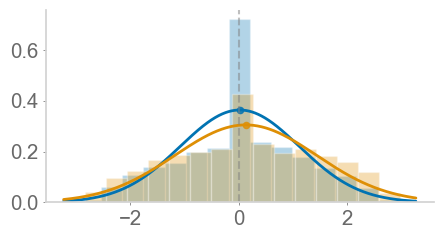

In [79]:
plot_selectivity_distribution_change(data)

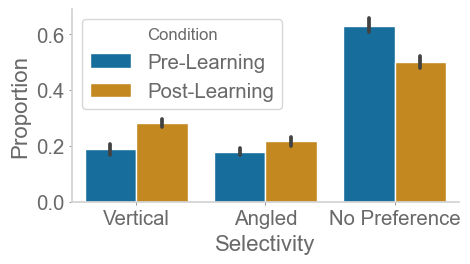

In [80]:
plot_selectivity_bar_change(data, thresh=1)